In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/ganxing/anaconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


要使用autogluon.timeseries，我们只需要以下两个类：

TimeSeriesDataFrame存储由多个时间序列组成的数据集。

TimeSeriesPredictor负责拟合、调整和选择最佳预测模型，以及生成新的预测。

我们加载 M4 每小时数据集的子集作为pandas.DataFrame

In [2]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


AutoGluon 需要长格式的时间序列数据。数据帧的每一行包含单个时间序列的单个观察（时间步长），表示为

时间序列的唯一 ID ( "item_id") 作为 int 或 str

观察的时间戳 ( "timestamp") 作为pandas.Timestamp兼容格式

时间序列的数值 ( "target")

原始数据集应始终遵循此格式，并至少包含三列：唯一 ID、时间戳和目标值，但这些列的名称可以是任意的。TimeSeriesDataFrame然而，重要的是，我们在构建AutoGluon 使用的列时提供列的名称。如果数据与预期格式不匹配，AutoGluon 将引发异常。

In [3]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

我们将存储在 a 中的每个单独的时间序列称为TimeSeriesDataFrame一个项目。例如，项目可能对应于需求预测中的不同产品，或者对应于金融数据集中的不同股票。此设置也称为时间序列面板。请注意，这与多元预测不同- AutoGluon 单独为每个时间序列生成预测，而不对不同项目（时间序列）之间的交互进行建模。
TimeSeriesDataFrame继承自pandas.DataFrame，因此 的所有属性和方法都pandas.DataFrame可以在TimeSeriesDataFrame. 它还提供其他实用函数，例如不同数据格式的加载器（有关详细信息，请参阅TimeSeriesDataFrame ）。

训练时间序列模型TimeSeriesPredictor.fit
为了预测时间序列的未来值，我们需要创建一个TimeSeriesPredictor对象。

autogluon.timeseries预测时间序列中的模型将迈向未来的多个步骤。我们根据我们的任务选择这些步骤的数量——预测长度（也称为预测范围）。例如，我们的数据集包含以每小时频率测量的时间序列，因此我们设置训练模型来预测未来 48 小时内的情况。prediction_length = 48

我们指示 AutoGluon 将训练好的模型保存在文件夹中./autogluon-m4-hourly。我们还指定 AutoGluon 应根据平均绝对比例误差 (MASE)"target"对模型进行排名，并且我们想要预测的数据存储在TimeSeriesDataFrame.

In [4]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.3.0: Mon Jan 30 20:39:35 PST 2023; root:xnu-8792.81.3~2/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.34 GB / 8.00 GB (16.7%)
Disk Space Avail:   51.66 GB / 228.27 GB (22.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 14806

这里我们使用"medium_quality"预设并将训练时间限制为 10 分钟（600 秒）。预设定义 AutoGluon 将尝试适应哪些模型。对于medium_quality预设，这些是简单的基线 ( Naive, SeasonalNaive)、统计模型 ( ETS、Theta)、基于 LightGBM 的基于树的模型 ( RecursiveTabular、DirectTabular)、深度学习模型TemporalFusionTransformer以及组合这些的加权集成。其他可用的预设TimeSeriesPredictor有"fast_training"、"high_quality"和"best_quality"。更高质量的预设通常会产生更准确的预测，但训练时间更长。

在内部fit()，AutoGluon 将在给定的时间内训练尽可能多的模型。然后根据训练后的模型在内部验证集上的表现对其进行排名。默认情况下，此验证集是通过保留prediction_length中每个时间序列的最后一个时间步来构建的train_data。

使用TimeSeriesPredictor.predict
我们现在可以使用拟合TimeSeriesPredictor来预测未来的时间序列值。默认情况下，AutoGluon 将使用在内部验证集上得分最高的模型进行预测。预测始终包括prediction_length从 中每个时间序列的末尾开始的下一个时间步长的预测train_data。

In [5]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  628.266367  608.160742  615.062590  620.039308   
        1750-01-30 05:00:00  558.064668  531.817389  540.827541  547.324495   
        1750-01-30 06:00:00  515.703113  484.740065  495.369043  503.033285   
        1750-01-30 07:00:00  484.100765  449.160071  461.154494  469.803316   
        1750-01-30 08:00:00  460.626424  422.179810  435.377743  444.894381   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  624.291730  628.266367  632.241003  636.493425   
        1750-01-30 05:00:00  552.875902  558.064668  563.253435  568.804842   
        1750-01-30 06:00:00  509.582096  515.703113  521.824130  528.372942   
        1750-01-30 07:00:00  477.193416  484.100765  491.008113  498.398213   
        1750-01-30 08:00:00  453.025997  460.626424  468.226850  476.358466   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  641.470143  648.371991  
        1750-01-30 05:00:00  575.301796  584.311947  
        1750-01-30 06:00:00  536.037183  546.666162  
        1750-01-30 07:00:00  507.047036  519.041458  
        1750-01-30 08:00:00  485.875104  499.073037

AutoGluon 产生概率预测：除了预测未来时间序列的平均值（期望值）之外，模型还提供预测分布的分位数。分位数预测让我们了解可能结果的范围。例如，如果"0.1"分位数等于500.0，则意味着模型预测目标值有 10% 的机会低于500.0。

现在，我们将可视化数据集中某个时间序列的预测和实际观测值。我们绘制平均预测以及 10% 和 90% 分位数来显示潜在结果的范围。

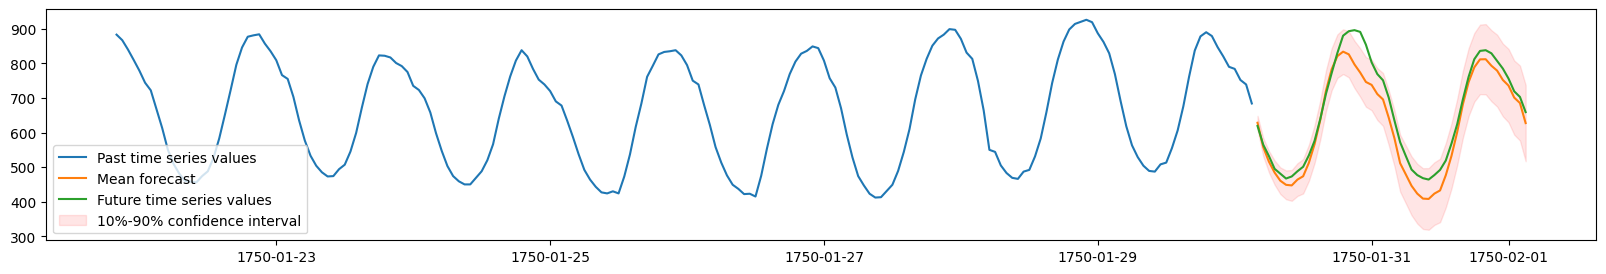

In [6]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();